In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
from obj_spec import multi_data

opt = torch.load('./opts_inter_out')
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test
Dataset = get_dataset(opt.dataset, opt.task)
val_loader = torch.utils.data.DataLoader(
    Dataset(opt, 'val'),
    batch_size=1,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

if opt.multi_res:
  train_loader=multi_data()
else:
    train_loader = torch.utils.data.DataLoader(
        Dataset(opt, 'train'),
        batch_size=opt.batch_size,
        shuffle=True,
        num_workers=opt.num_workers,
        pin_memory=True,
        drop_last=True
    )

==> initializing pascal test2007 data.
loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
Loaded val 4952 samples
==> initializing pascal trainval0712 data.
loading annotations into memory...
Done (t=3.50s)
creating index...
index created!
Loaded train 16551 samples


In [7]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
state_dict=torch.load('/home/mayx/project/github/CenterNet/exp/ctdet/pascal_resnet18_inter_bound_rehm/model_last.pth')
for k,v in state_dict.items():
    print(k)
    if 'epoch' in k:
        print(v)
params=state_dict['state_dict']
model.cuda()
model.load_state_dict(params)

=> loading pretrained model https://download.pytorch.org/models/resnet18-5c106cde.pth
=> init deconv weights from normal distribution
epoch
70
state_dict
optimizer


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

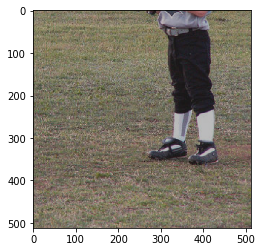

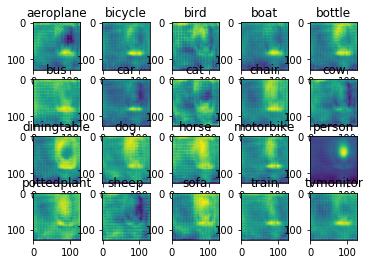

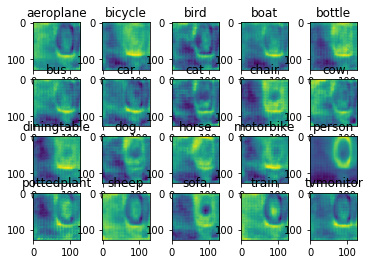

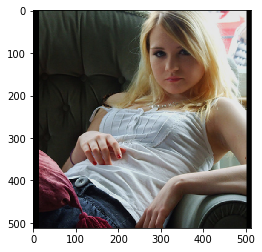

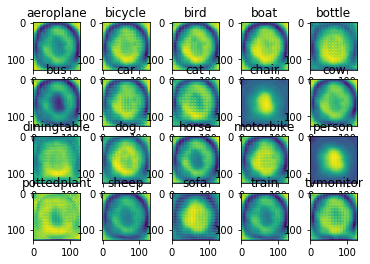

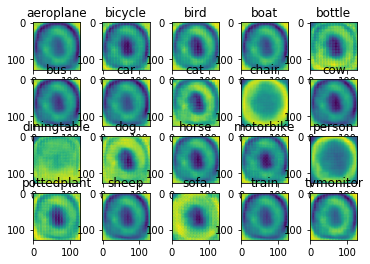

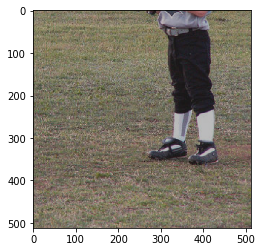

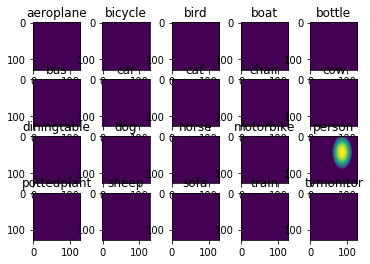

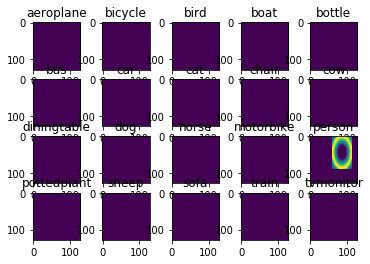

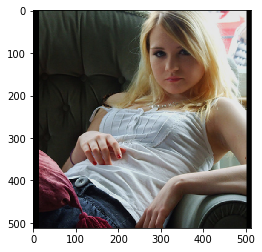

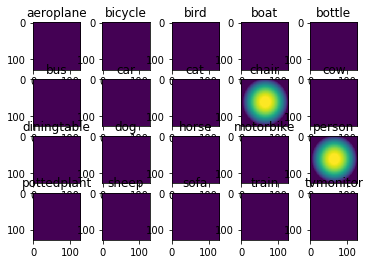

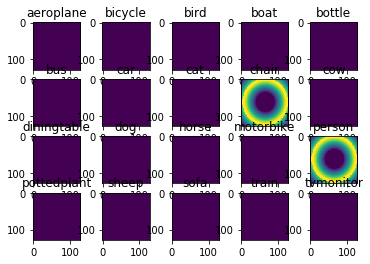

s


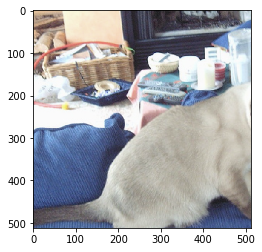

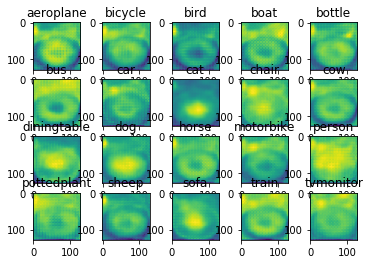

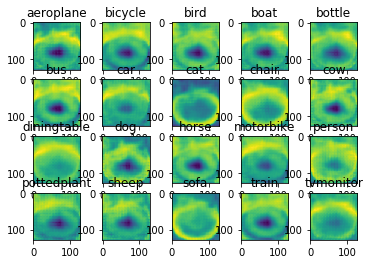

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


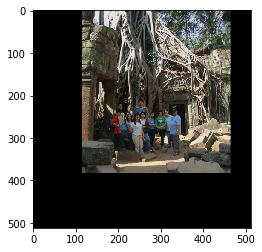

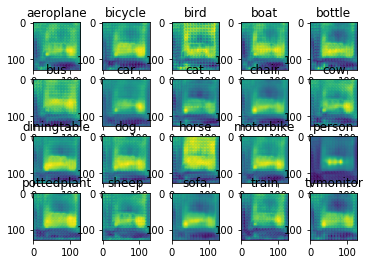

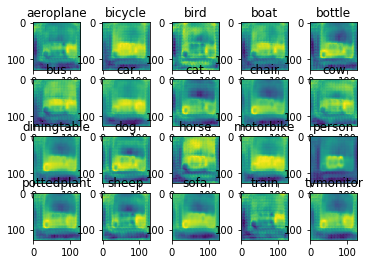

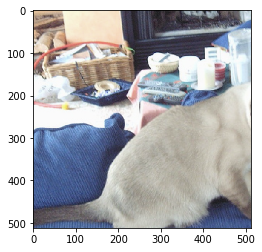

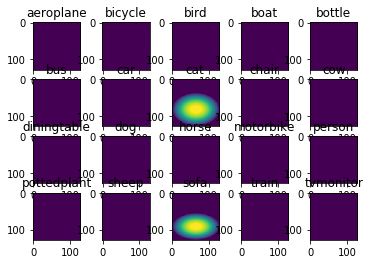

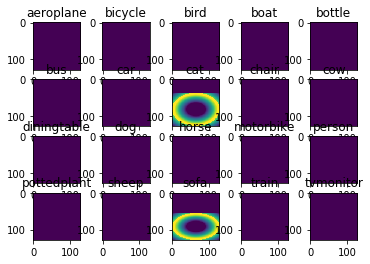

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


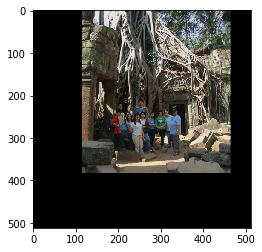

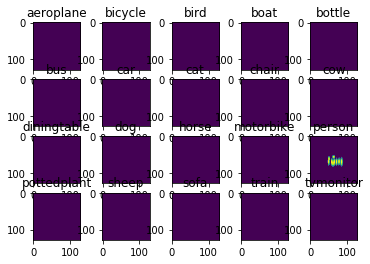

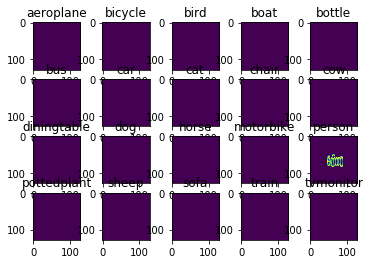

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,1,3)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,1,3)
def draw_pic_hm(data,hm_inter,hm_bound):
    classes=["aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", 
"horse", "motorbike", "person", "pottedplant", "sheep", "sofa", 
"train", "tvmonitor"]
    for pic,inter,bound in zip(data,hm_inter,hm_bound):
        plt.imshow(((pic.permute((1,2,0))*std+mean)*255).int())
        plt.show()
        for index,(label_hm) in enumerate(inter):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(label_hm)
        plt.show()
        for index,(label_hm) in enumerate(bound):
            plt.subplot(4,5,index+1)
            plt.title(classes[index])
            plt.imshow(label_hm)
        plt.show()
model.eval()
for index,batch in enumerate(train_loader):
    data=batch['input']
    data=data[:2].cuda()
    output,=model(data)
    for k in output:
        output[k]=output[k].cpu().detach()
    draw_pic_hm(data.cpu().detach(),output['hm'][:2],output['wh'][:2])
    draw_pic_hm(data.cpu().detach(),batch['hm_inter'][:2],batch['hm_bound'][:2])
    input('s')